<a href="https://colab.research.google.com/github/Nyandwi/tf_vision/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN Image Segmentation with TensorFlow

This is the implementation of the paper [Mask R-CNN Image Segmentation](https://arxiv.org/pdf/1703.06870.pdf). The trained model is fully part of TF Hub, a repo of trained Computer Vision models and it will be leveraged here instead of building it from scratch.

Below is a result produced by the Mask R-CNN segmentation architecture. 

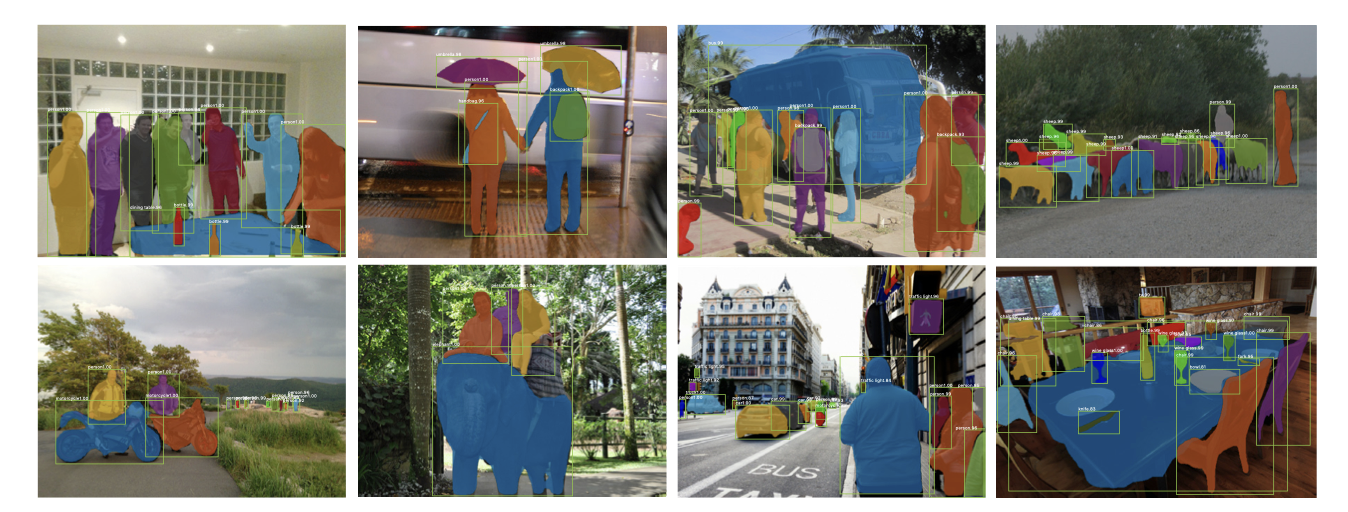

### Similar Segmentation papers:

*  [Fully Convolutional Networks for Semantic Segmentation (Long, Shelhamer & Darrell, 2014)](https://people.eecs.berkeley.edu/~shelhamer/data/fcn.pdf)

* [U-Net: Convolutional Networks for Biomedical Image Segmentation (Ronneberger, Fischer & Brox, 2015)](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

*  [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs (Chen, Papandreou, Kokkinos, Murphy, and Yuille, 2016)](http://liangchiehchen.com/projects/DeepLab.html).


### The outline of the work:

* *Installation of APIs and importing libraries* 
* *Image Processing functions* 
* *Getting the model from TensorFlow Hub* 
* *Performing the Inference* 
* *Visualizing the Results* 

### 1. Installation of Object Detection APIs and importing libraries

In [3]:
# We are going to use TensorFlow Object Detection API

# Cloning the object detection API

!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2648, done.
remote: Counting objects: 100% (2648/2648), done.
remote: Compressing objects: 100% (2192/2192), done.
remote: Total 2648 (delta 671), reused 1307 (delta 423), pack-reused 0
Receiving objects: 100% (2648/2648), 32.61 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (671/671), done.


In [4]:
%%bash 

sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1648944 sha256=5b88cf50ab6c0c8319e67416041a10be852444084ac21b833166d567df696769
  Stored in directory: /tmp/pip-ephem-wheel-cache-v405qj5z/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=8ffc146f820aec5a5ecdeaeeb285eb01e1f42e0e2492a6b2c22eab4d7db05779
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.



ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [5]:
# Importing libraries

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

### 2. Image Processing function

The function below `image_to_array` will load and convert the image into the NumPy array. 

In [6]:
def image_to_array(path):

  image = None

  if (path.startswith('http')):

    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)

  else:

    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

    (im_width, im_height) = (image.size)

    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)


In [7]:
# Dictionary with Test images provided by the Beach API
# Dictionary with image tags as keys and image paths as values

TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}

### 3. Getting the model from TensorFlow Hub

Mask R-CNN model is part of the TensorFlow Hub, it is built with the Object Detection API. Learn more at [tfhub.dev](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1).

In [8]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024X1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model: {}'.format(model_display_name))
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model: Mask R-CNN Inception ResNet V2 1024X1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [9]:
# This will take more than 10 minutes to finish 

print('loading the model...')
hub_model = hub.load(model_handle)
print('model_loaded!')

loading the model...
model_loaded


### 4. Performing the Inference

We are going to use the model we loaded to do the instance segmentation on an image. We will also choose one of the test images

In [11]:
# Choose one and use as key for TEST_IMAGES below: 
# ['Beach', 'Street', 'Dogs','Phones']

image_path = TEST_IMAGES['Street']

image_np = image_to_array(image_path)

plt.figure(figsize = (24, 32))
plt.imshow (image_np[0])
plt.show()

TypeError: ignored

<Figure size 1728x2304 with 0 Axes>

We are now going to run inference by passing the numpy array of one image (model doesn't support batching). The output will be a dictionary containing the results. 

In [ ]:
# run inference 

results = hub_model(image_np)

# output values are tensors and we only need the numpy()
# parameter when we visualize the results

result = {key:value.numpy() for key,value in results.items()}

# print the keys

for key in result.keys():
  print(key)

### 5. Visualizing the Results

In [14]:
# The model was trained on the COCO2017 dataset and the API package has the labels saved in a different format (i.e. mscoco_label_map.pbtxt). 
# You can use the create_category_index_from_labelmap internal utility function to convert this to the required dictionary format.


PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


# sample output

print(category_index[1])
print(category_index[2])
print(category_index[4])


{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


Before we plot the results:

* We are process the masks. The dictionary contains a detection_masks key containing segmentation masks for each box. It will be converted first to masks that will overlay to the full image size.
*  Select mask pixel values that are above a certain threshold. It is set to `0.6`. Lower value will cause the mask pixesl to be outside the object

* The function `visualize_boxes_and_labels_on_image_array()` will be used to plot the result on the image. 

In [ ]:
# handle models with masks

label_id_offset = 0
image_np_with_mask = image_np.copy()


if 'detection_masks' in result:

  # convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # reframe the the bounding box mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])

  # filter mask pixel values that are above a specified threshold
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6,
                                      tf.uint8)
  
  # get the numpy array
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()


```
Credits:

* TensorFlow Hub, Mask R-CNN Object detection model,trained on COCO 2017 dataset.
* TensorFlow Object Detection API
```

